<a href="https://colab.research.google.com/github/nedokormysh/GB_PyTorch/blob/lesson5/GB_PyTorch_hw_5_dirty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Домашнее задание

1. Необходимо подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples для обучения модели на сегментацию губ
2. Обучить модель на выбор из [segmentation_models_pytorch](https://segmentation-modelspytorch.readthedocs.io/en/latest/index.html)

In [43]:
! pip install git+https://github.com/qubvel/segmentation_models.pytorch -q
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import metrics

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [44]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import matplotlib.pyplot as plt
import albumentations as alb

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, Dataset, sampler
from PIL import Image
from torchvision import transforms
from torch.nn import functional as F
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
from torch.nn import functional as F
from sklearn.model_selection import train_test_split

In [45]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
! mkdir ~/.kaggle

from google.colab import files

files.upload()

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


Saving kaggle.json to kaggle (1).json


In [12]:
! kaggle datasets download olekslu/makeup-lips-segmentation-28k-samples

100% 2.37G/2.38G [00:20<00:00, 155MB/s]
100% 2.38G/2.38G [00:20<00:00, 127MB/s]


In [13]:
! unzip -q '/content/makeup-lips-segmentation-28k-samples.zip'

In [46]:
DATA_ROOT = '/content/set-lipstick-original'

IMAGE_DATASET_PATH = '/content/set-lipstick-original/720p'
MASK_DATASET_PATH = '/content/set-lipstick-original/mask/'

list_frame = pd.read_csv('/content/set-lipstick-original/list.csv')
list_frame['img_filename'] = DATA_ROOT + '/720p/' + list_frame['filename']
list_frame['mask_filename'] = DATA_ROOT + '/mask/' + list_frame['mask']

list_frame.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask,img_filename,mask_filename
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png,/content/set-lipstick-original/720p/image00000...,/content/set-lipstick-original/mask/mask000000...
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png,/content/set-lipstick-original/720p/image00000...,/content/set-lipstick-original/mask/mask000000...
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png,/content/set-lipstick-original/720p/image00000...,/content/set-lipstick-original/mask/mask000000...
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png,/content/set-lipstick-original/720p/image00000...,/content/set-lipstick-original/mask/mask000000...
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png,/content/set-lipstick-original/720p/image00000...,/content/set-lipstick-original/mask/mask000000...


In [47]:
list_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28594 entries, 0 to 28593
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   filename       28594 non-null  object
 1   width          28594 non-null  int64 
 2   height         28594 non-null  int64 
 3   class          28594 non-null  object
 4   xmin           28594 non-null  int64 
 5   ymin           28594 non-null  int64 
 6   xmax           28594 non-null  int64 
 7   ymax           28594 non-null  int64 
 8   mask           28594 non-null  object
 9   img_filename   28594 non-null  object
 10  mask_filename  28594 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.4+ MB


In [47]:
# list_frame.describe()

In [55]:
# images = []
# masks = []
# for root, dirs, files in os.walk(DATA_ROOT):
#     for name in files:
#         f = os.path.join(root, name)
#         if '720p' in f:
#             images.append(f)
#         elif 'mask' in f:
#             masks.append(f)
            
# print(f'Количество изображений - {len(images)}.')
# print(f'Количество масок - {len(masks)}.')

In [54]:
# df = pd.read_csv(DATA_ROOT + '/list.csv')
# df['img_filename'] = DATA_ROOT + '/720p/' + df['filename']
# df['mask_filename'] = DATA_ROOT + '/mask/' + df['mask']
# df.info()

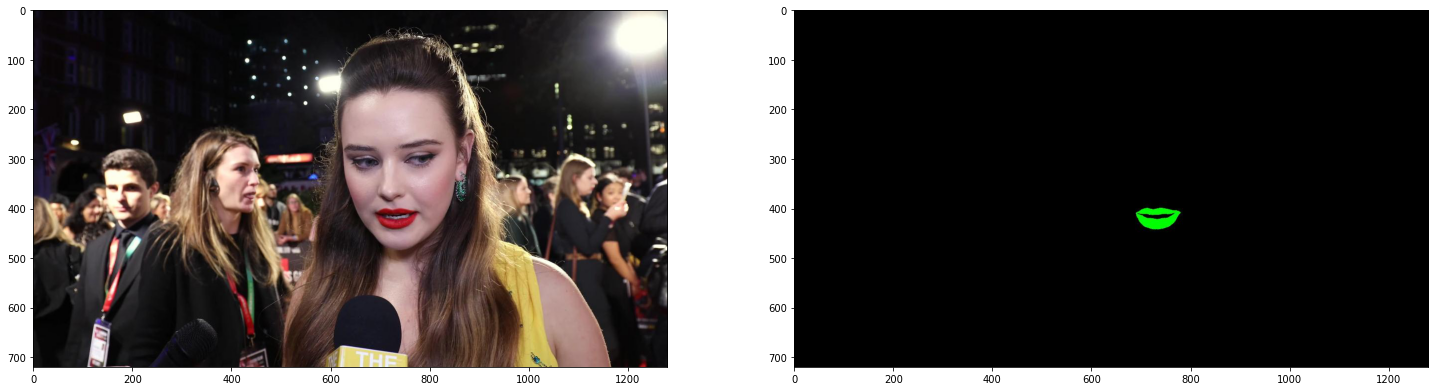

In [48]:
img = plt.imread(IMAGE_DATASET_PATH + '/image00000650.jpg')
mask = plt.imread(MASK_DATASET_PATH + '/mask00000650.png')
fig, axes = plt.subplots(1, 2, figsize=(25, 50))
axes[0].imshow(img)
axes[1].imshow(mask)

Создадим класс для кастомного датасета:

In [49]:
class LipsDataset(Dataset):
    def __init__(self, data, preprocessing=None):
        # Подаем наш подготовленный датафрейм
        self.data = data
        
        # Разделяем датафрейм на rgb картинки 
        self.image_arr = self.data['img_filename']
        # и на сегментированные картинки
        self.label_arr = self.data['mask_filename']
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data.index)
        
        self.preprocessing = preprocessing

        
    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        img = cv2.cvtColor(cv2.imread(self.image_arr[index]), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))

        img = np.asarray(img).astype('float')
        
        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)
        else:
            # Нормализуем изображение в значениях [0, 1]
            img = torch.as_tensor(img) / 255.0
        img = img.permute(2,0,1)
        
        # считаем сегментированную картинку
#         masks = []
#         mask = cv2.cvtColor(cv2.imread(self.label_arr[index]), cv2.COLOR_BGR2RGB)
#         mask = mask.resize((256, 256))
# #         mask = Image.open(self.label_arr[index])
# #         mask = mask.resize((256, 256))
# #         mask = np.asarray(mask)
        
        mask = cv2.cvtColor(cv2.imread(self.label_arr[index]), cv2.COLOR_BGR2RGB)    
        mask = cv2.resize(mask, (256, 256))
        mask = np.asarray(mask).astype('float')
        mask = torch.as_tensor(mask) / 255.0  
        mask = mask.permute(2,0,1)

        # for i in range(13):
        #     cls_mask = np.where(mask == i, 255, 0)
        #     cls_mask = cls_mask.astype('float')
        #     cls_mask = cv2.resize(cls_mask, (256, 256))

        #     masks.append(cls_mask[:,:,0] / 255)
            
        # masks = torch.as_tensor(masks, dtype=torch.uint8)    
        
            
        return (img.float(), mask.float())

    def __len__(self):
        return self.data_len

Создание модели

In [9]:
BACKBONE = 'resnet34'
segmdl = smp.Unet(BACKBONE, in_channels=3, classes=2, activation='sigmoid').to(device)
preprocess_input = smp.encoders.get_preprocessing_fn(BACKBONE, pretrained='imagenet')

In [10]:
dataset = LipsDataset(list_frame, preprocessing=preprocess_input)
img, masks = dataset[650]
print(img.shape, masks.shape)

torch.Size([3, 256, 256]) torch.Size([3, 256, 256])


torch.Size([3, 256, 256]) torch.Size([3, 256, 256])


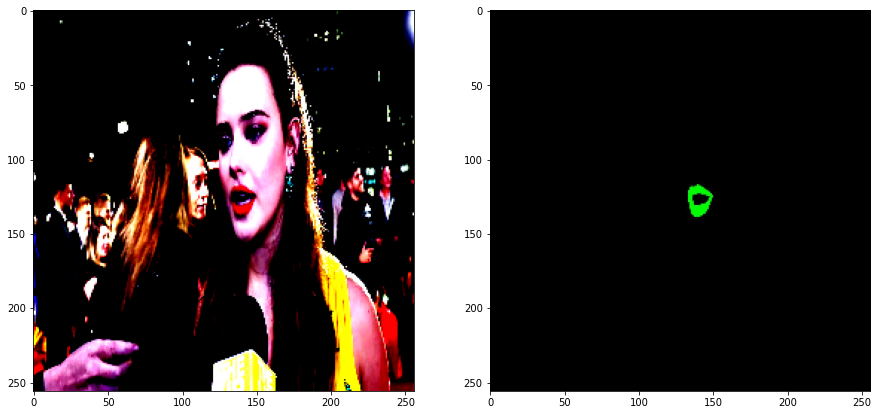

In [13]:
dataset = LipsDataset(list_frame, preprocessing=preprocess_input)
img, masks = dataset[650]
print(img.shape, masks.shape)
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(masks.permute(1, 2, 0))
# plt.show()

In [130]:
# img[0].type()

In [129]:
# type(mask[0])

In [131]:
# image_arr = list_frame['img_filename']
# image_arr[0]
# # a = cv2.imread(image_arr[0])
# img = cv2.cvtColor(cv2.imread(image_arr[0]), cv2.COLOR_BGR2RGB)
# # img = cv2.cvtColor(a)

Разделим датасет на тренировочный и тестовый

In [14]:
from sklearn.model_selection import train_test_split

# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(list_frame, test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = LipsDataset(X_train)
test_data = LipsDataset(X_test)

In [15]:
train_data_loader = DataLoader(
    train_data,
    batch_size=8,
    shuffle=True
)
test_data_loader = DataLoader(
    test_data,
    batch_size=4,
    shuffle=False
)

In [ ]:
# smp.losses.DiceLoss
# smp.metrics.iou_score

In [17]:
# ! pip install segmentation_models_pytorch -q
# import segmentation_models_pytorch as smp

In [33]:
# ! pip install git+https://github.com/qubvel/segmentation_models.pytorch -q
# import segmentation_models_pytorch as smp
# from segmentation_models_pytorch import metrics
# import segmentation_models_pytorch.utils.metrics as mtrcs

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [34]:
# ! pip install torchmetrics

In [39]:
criterion = smp.utils.losses.DiceLoss
metrics = [smp.utils.metrics.IoU(threshold=0.5)]
optimizer = torch.optim.Adam(params=segmdl.parameters(), lr=0.001)

In [26]:
# # criterion = smp.utils.losses.DiceLoss
# # metrics = [smp.utils.metrics.IoU(threshold=0.5)]
# from torchmetrics.classification import BinaryJaccardIndex
# criterion = smp.losses.DiceLoss(mode='binary')
# metrics = BinaryJaccardIndex()

# optimizer = torch.optim.Adam(params=segmdl.parameters(), lr=0.001)

In [42]:
train_epoch = smp.utils.train.TrainEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

NameError: ignored

In [ ]:
torch.device.

## Рисование графика

In [ ]:
def get_orig(image):
    image = image.permute(1, 2, 0)
    image = image.numpy()
    image = np.clip(image, 0, 1)
    return image